Initalizing packages and functions

In [65]:
import torch
import torchvision
import sklearn
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Enabling CUDA

In [66]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda:0 device


Hyper parameteres:

In [67]:
n_epochs = 3 # How many times we loop over train dataset
batch_size_train = 64 #How many images we use in one go for training
batch_size_test = 50
learning_rate = 0.025 #step size in gradient descent
momentum = 0.9  # a hyper paremeter that helps in converging faster and avoding local minima during gradient descent
log_interval = 10 # How often we print out results
torch.backends.cudnn.enabled = True # for faster computation

Importing and formating the data:

In [68]:

# Define transformations
transformations = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize images to the same size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load custom dataset
train_dataset = torchvision.datasets.ImageFolder(
    root=r'C:\Users\necad\OneDrive\Desktop\ML\train',  # Replace with your train dataset path
    transform=transformations
)

test_dataset = torchvision.datasets.ImageFolder(
    root=r'C:\Users\necad\OneDrive\Desktop\ML\test',  # Replace with your test dataset path
    transform=transformations
)

# Create DataLoader instances
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size_train,  # Define batch_size_train 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size_test,  # Define batch_size_test 
    shuffle=True
)

Loading batch

In [69]:
examples = enumerate(test_loader) 
batch_idx, (example_data, example_targets) = next(examples) 

VIewing images

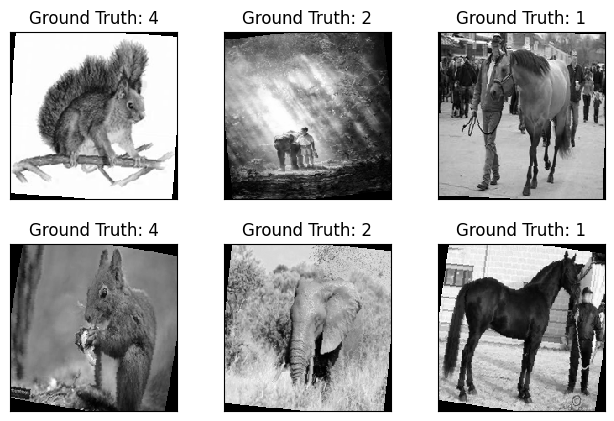

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    # Check if the image is single-channel and set the colormap to 'gray' if it is
    cmap = 'gray' if example_data[i][0].shape[-1] == 1 else 'gray'
    plt.imshow(example_data[i][0], interpolation='none', cmap=cmap)
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()   #some parent thing
        self.flatten = nn.Flatten()    #flatten the image
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,padding=1)    #can exchange with linear 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.drop = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12*12*256, 512)
        self.fc2 = nn.Linear(512, 5)
    def forward(self, x):      #Cnvolution feed forward?
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        x=F.relu(self.conv3(x))
        x=self.pool(x)
        x=F.relu(self.conv4(x))
        x=self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x= self.drop(x)
        x= self.fc2(x)

        return F.log_softmax(x,dim=-1)

Initialize network

In [72]:
network = Net()
network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Start training model

In [73]:
train_losses=[]
train_counter=[i*batch_size_train for i in range(len(train_loader)*n_epochs)]
test_losses=[]
test_counter=[i*len( train_loader.dataset) for i in range(n_epochs +1)]
print (len(train_counter))


594


Defining training

In [74]:
def train(epoch):
    network.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data=data.to(device)
        target=target.to(device)
        optimizer.zero_grad()   #WHAT DOES THIS TO CHECK
        output= network(data) # I defined this class os why does this work
        loss= F.nll_loss(output,target)  #size average renormalizes loss
        train_loss = loss.item()
        train_losses.append(train_loss)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval ==0:
            print('train Epoch: {} [{}/{}({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx*len(data),len(train_loader.dataset),100.* batch_idx/ len(train_loader),loss.item()))
     

Define test epoch

In [75]:
from sklearn.metrics import accuracy_score

def test():
    network.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # This is as we do not back propagate
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            
            # Collect predictions and true labels
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        # Calculate accuracy
        accuracy = accuracy_score(all_targets, all_preds)
        print(f'Accuracy: {accuracy * 100:.2f}%')


RUN program

In [76]:
test()
for epoch in range(1, n_epochs+1):
    train(epoch)
    test()

Accuracy: 18.00%
train Epoch: 1 [0/12656(0%)]	Loss: 1.615811
train Epoch: 1 [640/12656(5%)]	Loss: 1.565757
train Epoch: 1 [1280/12656(10%)]	Loss: 1.538995
train Epoch: 1 [1920/12656(15%)]	Loss: 1.574730
train Epoch: 1 [2560/12656(20%)]	Loss: 1.518651
train Epoch: 1 [3200/12656(25%)]	Loss: 1.525285
train Epoch: 1 [3840/12656(30%)]	Loss: 1.352115
train Epoch: 1 [4480/12656(35%)]	Loss: 1.468609
train Epoch: 1 [5120/12656(40%)]	Loss: 1.385737
train Epoch: 1 [5760/12656(45%)]	Loss: 1.339571
train Epoch: 1 [6400/12656(51%)]	Loss: 1.353366
train Epoch: 1 [7040/12656(56%)]	Loss: 1.256100
train Epoch: 1 [7680/12656(61%)]	Loss: 1.166383
train Epoch: 1 [8320/12656(66%)]	Loss: 1.205175
train Epoch: 1 [8960/12656(71%)]	Loss: 1.081385
train Epoch: 1 [9600/12656(76%)]	Loss: 1.197573
train Epoch: 1 [10240/12656(81%)]	Loss: 1.317600
train Epoch: 1 [10880/12656(86%)]	Loss: 1.173823
train Epoch: 1 [11520/12656(91%)]	Loss: 1.124560
train Epoch: 1 [12160/12656(96%)]	Loss: 1.410475
Accuracy: 45.60%
train Ep

PLOT TRAINING CURVE

Text(0, 0.5, 'negative log likelihood loss')

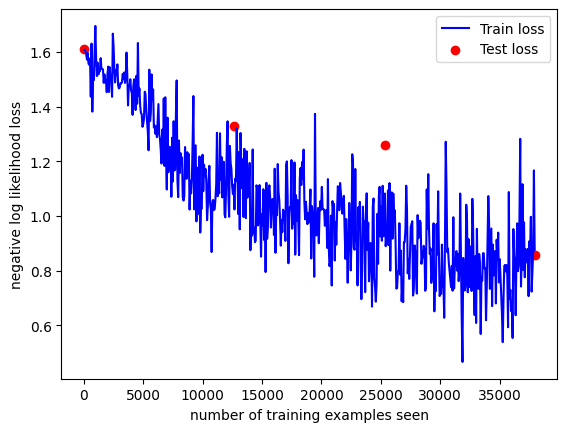

In [ ]:
fig = plt.figure()
plt.plot(train_counter,train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train loss','Test loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
